In [1]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'


seaborn: 0.13.2


In [2]:
_df = df[["passengers", "distance", "fare"]][:5]
tbl.show_num_df(
    _df,
    total_axis="xy",
    total_mode="mean",
    data_bar_axis="xy",
    pct_axis="",
    precision=2,
    # show_as_pct=True,
    # kpi_mode="",
    # kpi_mode="max_min_x",
    # kpi_rag_list=(1,7),
)

,passengers,distance,fare,Total
0,1.00,1.60,7.00,3.20
1,1.00,0.79,5.00,2.26
2,1.00,1.37,7.50,3.29
3,1.00,7.70,27.00,11.90
4,3.00,2.16,9.00,4.72
Total,1.40,2.72,11.10,5.07


In [3]:
# sys.exit()

🔵 *** df: dataframe ***
🟣 shape: (6_433, 14) columns: ['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough'] 
🟣 duplicates: 0
🟣 missings: {'pickup': 0, 'dropoff': 0, 'passengers': 0, 'distance': 0, 'fare': 0, 'tip': 0, 'tolls': 0, 'total': 0, 'color': 0, 'payment': 44, 'pickup_zone': 26, 'dropoff_zone': 45, 'pickup_borough': 26, 'dropoff_borough': 45}
--- column uniques (all)
🟠 index [0, 1, 2, 3, 4,]
🟠 pickup(6_414|datetime64[ns]) [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53, ]
🟠 dropoff(6_425|datetime64[ns]) [2019-02-28 23:32:35, 2019-03-01 00:13:32, 2019-03-01 00:29:47, 2019-03-01 00:32:48, ]
🟠 passengers(7|int64) [0, 1, 2, 3, 4,]
🟠 distance(1_079|float64) [0.0, 0.01, 0.02, 0.03, 0.04,]
🟠 fare(220|float64) [1.0, 2.5, 3.0, 3.5, 4.0,]
🟠 tip(489|float64) [0.0, 0.01, 0.02, 0.06, 0.08,]
🟠 tolls(16|float64) [0.0, 2.64, 4.75, 5.54, 5.75,]
🟠

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


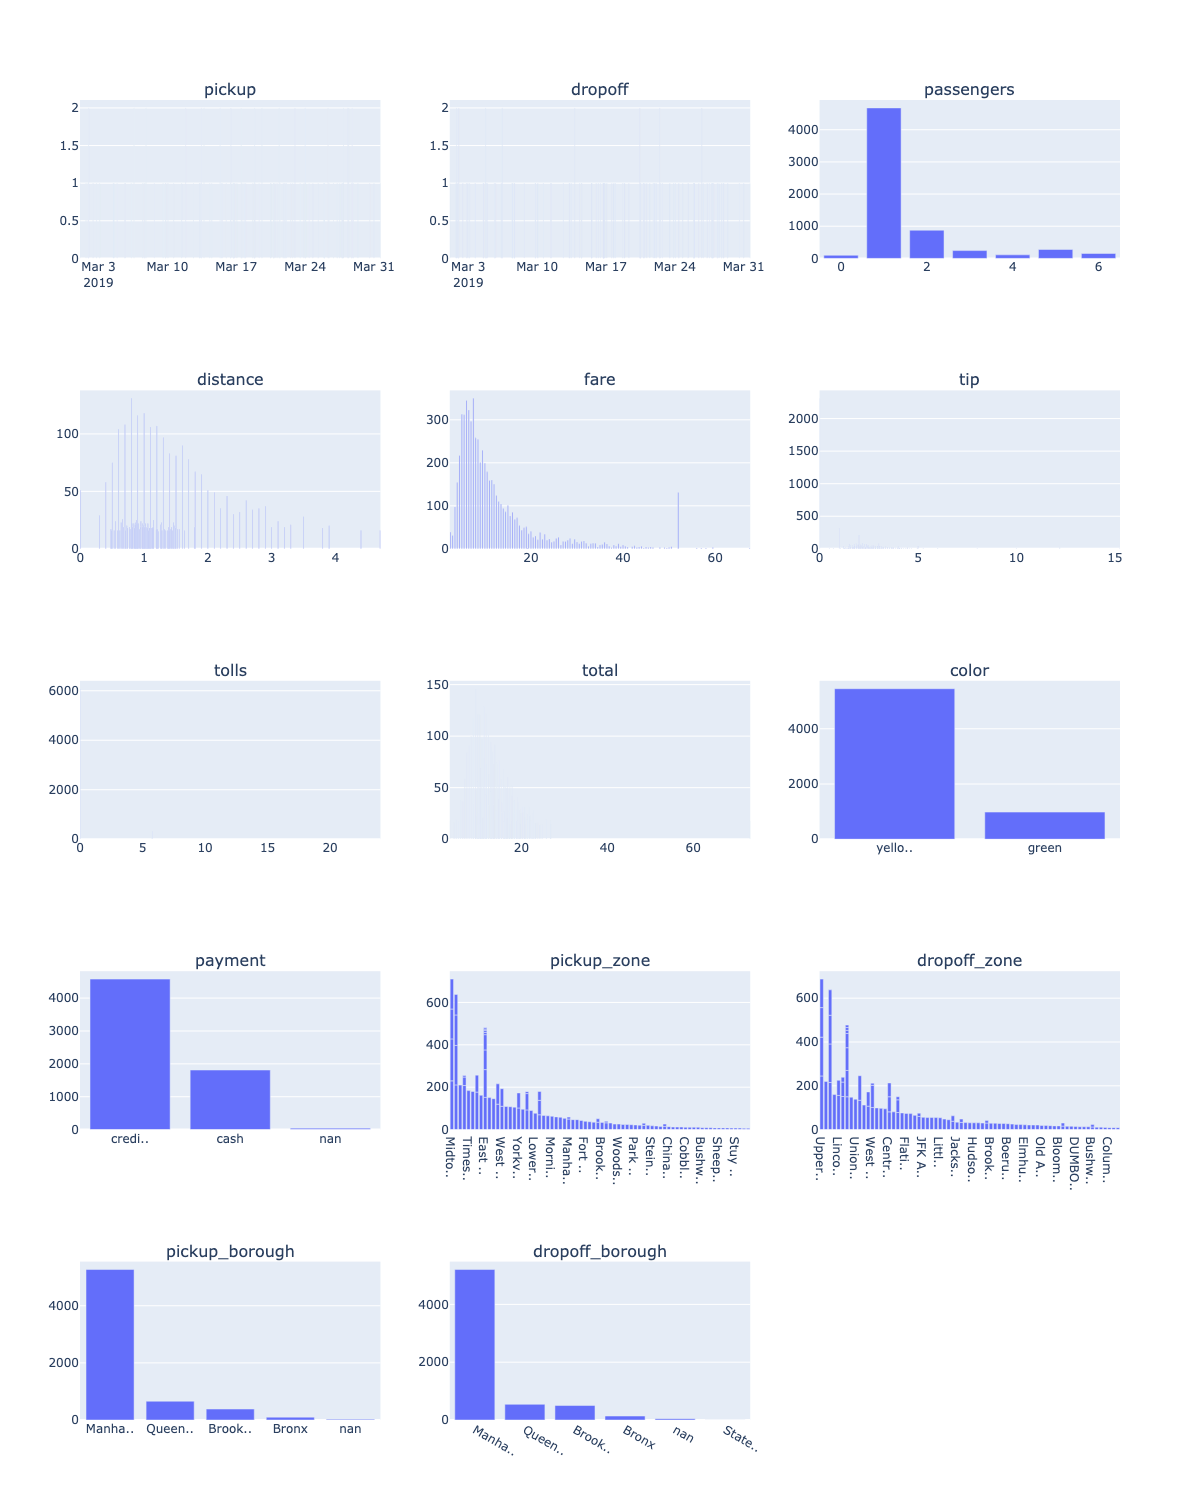

In [4]:

tbl.describe_df(df, 'dataframe', top_n_uniques=5, top_n_chars_in_index=5)
# lol=txt.wrap(list(df['passengers'].sort_values().value_counts().index), max_items_in_line=40)
# lol=wrap('kldjfldjfljö', max_items_in_line=40)
# lol=list(df['passengers'].value_counts().sort_index().index)[:3]
# lol
# txt.wrap(lol)

In [5]:
_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)

In [6]:
_df=df[["color", "payment", "fare"]]
tbl.pivot_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

payment,,cash,credit card,Total
color,,,,
green,20 (0.0%) 🟥,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,13_788 (16.4%)
yellow,508 (0.6%) 🟩,17_012 (20.2%) 🟩,52_907 (62.8%) 🟩,70_427 (83.6%)
Total,528 (0.6%) ⬜,21_006 (24.9%) ⬜,62_681 (74.4%) ⬜,84_215 (100.0%)


In [7]:
_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)
tbl.show_num_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

payment,cash,credit card,nan,Total
color,,,,
green,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,20 (0.0%) 🟥,13_788 (16.4%)
yellow,17_012 (20.2%) 🟩,52_907 (62.8%) 🟩,508 (0.6%) 🟩,70_427 (83.6%)
Total,21_006 (24.9%) ⬜,62_681 (74.4%) ⬜,528 (0.6%) ⬜,84_215 (100.0%)


abc --> cars1 | cars2 | cars3 --> len: 11
ab --> cars1 | cars2 --> len: 7
ac --> cars1 | cars3 --> len: 8
bc --> cars2 | cars3 --> len: 9


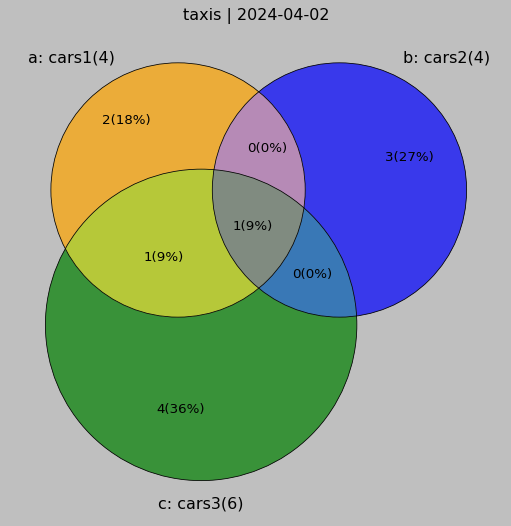

In [8]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

In [9]:
# plotly
import plotly_express as px

_fig=px.bar(_df, x=_df.index, y=_df.columns, title="taxis", text_auto=True, orientation="v")
_fig.update_layout(barnorm="percent")

_fig.show()
_df

,all,cars1,cars2
0,opel,NaN,opel
1,bentley,NaN,bentley
2,audi,NaN,audi
3,bmw,bmw,bmw
4,ford,ford,NaN
5,ferrari,ferrari,NaN
6,mercedes,mercedes,NaN


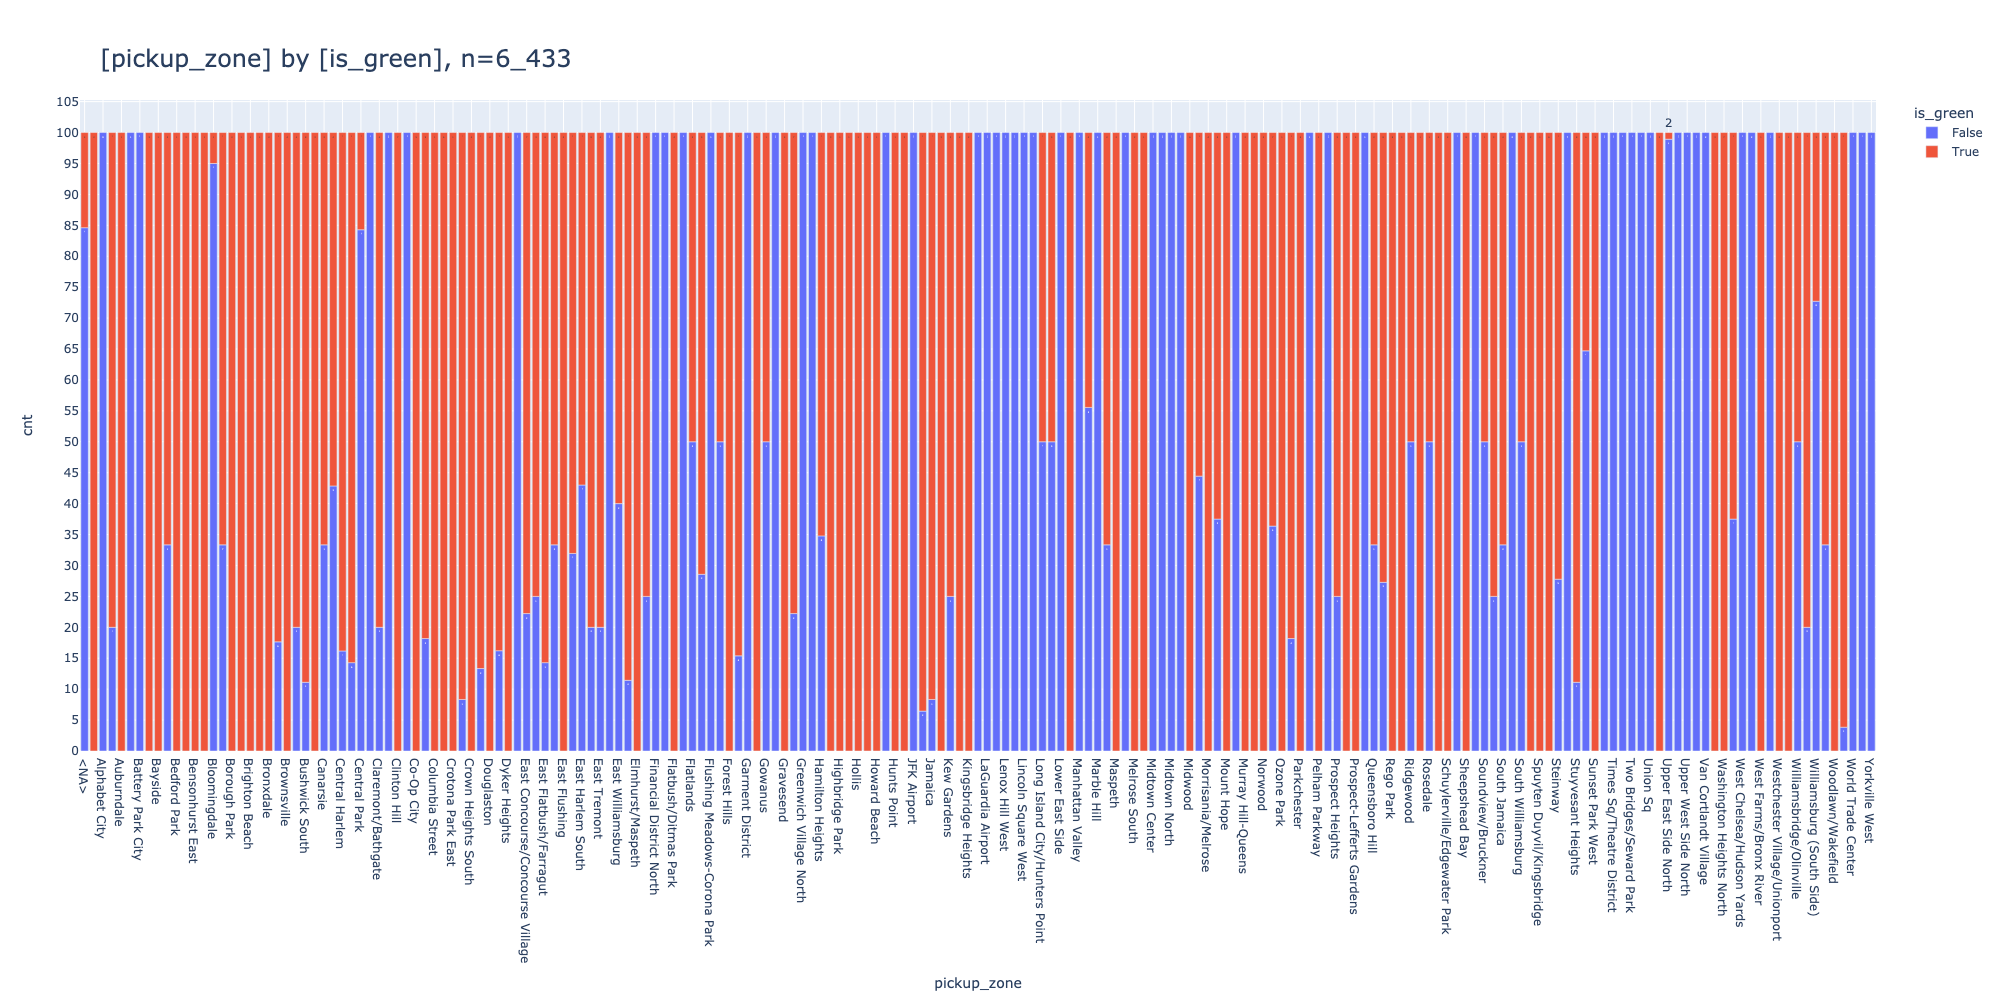

In [10]:
from pandas_plots import pls

_df = df
_df['is_green']=_df['color'].apply(lambda x: x=='green')

pls.plot_stacked_bars(
    _df[["is_green", "pickup_zone"]][:15000],
    swap=True,
    orientation="v",
    normalize=False,
    relative=True,
    height=1000,
)

In [11]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
tbl.show_num_df(
    _df,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

,distance,fare,tip,tolls,Total
0,1.600 (2.0%),7.000 (8.7%),2.150 (2.7%),0,10.750 (13.3%)
1,0.790 (1.0%),5.000 (6.2%),0,0,5.790 (7.2%)
2,1.370 (1.7%),7.500 (9.3%),2.360 (2.9%),0,11.230 (13.9%)
3,7.700 (9.5%),27.000 (33.4%),6.150 (7.6%),0,40.850 (50.5%)
4,2.160 (2.7%),9.000 (11.1%),1.100 (1.4%),0,12.260 (15.2%)
Total,13.620 (16.8%),55.500 (68.6%),11.760 (14.5%),0,80.880 (100.0%)


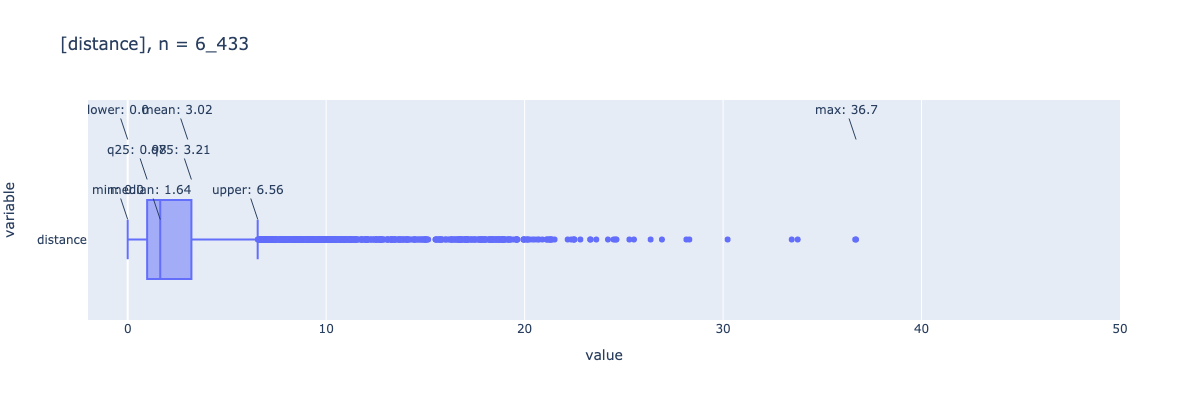

In [12]:
pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    x_max=50,
)

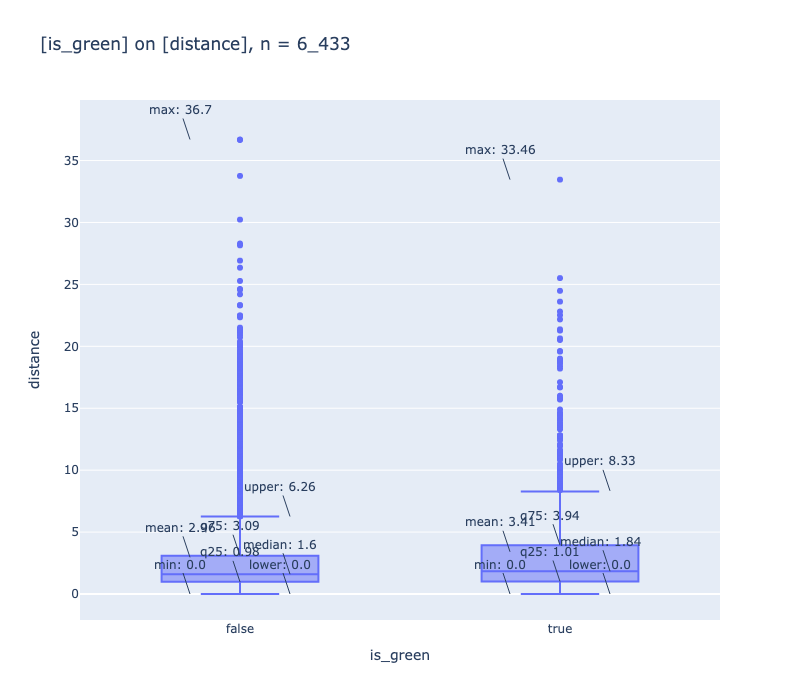

,color,distance,is_green
0,yellow,1.60,False
1,yellow,0.79,False
2,yellow,1.37,False
3,yellow,7.70,False
4,yellow,2.16,False
...,...,...,...
6428,green,0.75,True
6429,green,18.74,True
6430,green,4.14,True
6431,green,1.12,True


In [13]:
_df=df[['color','distance']]
_df['is_green']=_df['color'].apply(lambda x: x=='green')
pls.plot_boxes(_df[['is_green','distance']], height=700, )
_df
# pd.api.types.is_bool_dtype(_df['is_green'])

## new test

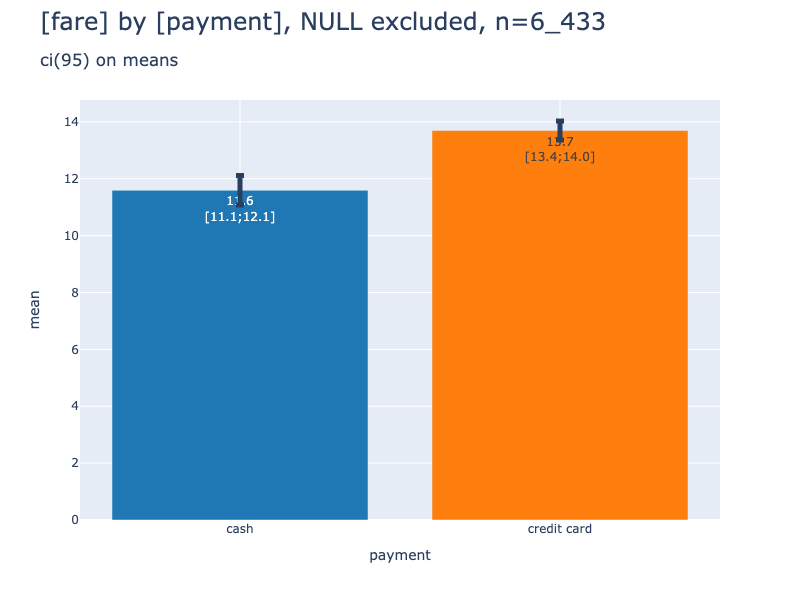

In [14]:
_df = df[["payment", "fare"]]
pls.plot_bars(
    _df,
    dropna=False,
    use_ci=True,
    height=600,
    width=800,
    precision=1,
    normalize=False,
)

In [15]:

# lol=_df2.reset_index()[["payment","fare"]]
# lol=lol[lol["payment"] == "cash"]
# lol
# hlp.mean_confidence_interval(_df1)

## barcode

In [16]:
from pandas_plots import hlp
url="https://github.com/robert-koch-institut/Bundesweiter_klinischer_Krebsregisterdatensatz-Datenschema_und_Klassifikationen"
# url="http://google.com"

# hlp.create_barcode_from_url(
#     url=url,
#     output_path=".local/zfkd-repo.png",
#     show_image=True,
# )

In [17]:
# df
# from pandas_plots import hlp
hlp.add_datetime_columns(df,"dropoff")
# df

⏳ Adding datetime columns basing off of: dropoff


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,...,pickup_borough,dropoff_borough,is_green,YYYY,MM,Q,YYYY-MM,YYYYQ,YYYY-WW,DDD
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,...,Manhattan,Manhattan,False,2019,3,1,2019-03,2019Q1,2019-W12,Sat
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,...,Manhattan,Manhattan,False,2019,3,1,2019-03,2019Q1,2019-W10,Mon
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,...,Manhattan,Manhattan,False,2019,3,1,2019-03,2019Q1,2019-W13,Wed
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,...,Manhattan,Manhattan,False,2019,3,1,2019-03,2019Q1,2019-W10,Sun
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,...,Manhattan,Manhattan,False,2019,3,1,2019-03,2019Q1,2019-W13,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,...,Manhattan,Manhattan,True,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,...,Queens,Bronx,True,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,...,Brooklyn,Brooklyn,True,2019,3,1,2019-03,2019Q1,2019-W12,Sat
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,...,Brooklyn,Brooklyn,True,2019,3,1,2019-03,2019Q1,2019-W10,Mon
